In [1]:
# Load packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.preprocessing import OneHotEncoder, LabelEncoder


# Read data
data_ml = pd.read_csv('data_ml.csv')

# 1 Feature Engineering

The dataset was partially processed during the exploratory data analysis (Part 1): Datatypes were changed. Redundant variables were deletet, outliers were and missing values were transformed (-> see Part 1: Exploratory Data Analysis)

## 1.1 Delete/Transform Features

In [2]:
# Delete first column
data_ml = data_ml.iloc[:,1:]


# Delete TotalCharges because doesn´t contribute to the prediction (Product of tenure*MonthlyCharges) 
data_ml = data_ml.drop(columns='TotalCharges')


# Replace 'No internet service' to 'No' to avoid multicollinearity in features with no internet services
features_no_internet = data_ml[['OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']].columns
for col in features_no_internet:
    data_ml[col] = data_ml[col].replace({'No internet service': 'No'})

## 1.2 Scaling Feature 'tenure'

In [3]:
def minimal_duration (x):
    if x['Contract'] == 'Month-to-month':
        return x['tenure'] - 1
    elif x['Contract'] == 'One year':
        return x['tenure'] - 12
    elif x['Contract'] == 'Two year':
        return x['tenure'] - 24

# Apply function in new column
data_ml['tenure_minimal_duration'] = data_ml.apply(minimal_duration,axis=1)


# Drop feature tenure
data_ml = data_ml.drop(columns='tenure')

## 1.3 One Hot Encoding

In [4]:
# Separiere kategorische und numerische Spalten
data_cat = data_ml.select_dtypes(include=['object', 'category']).copy()
data_num = data_ml.select_dtypes(include=['float64', 'int64']).copy()

# Leere DataFrames für encoded Data
data_le = pd.DataFrame(index=data_cat.index)
multi_cat_cols = []

# Label-Encoding für binäre Kategorien
le = LabelEncoder()
for col in data_cat.columns:
    if data_cat[col].nunique() == 2:
        data_le[col] = le.fit_transform(data_cat[col])
    else:
        multi_cat_cols.append(col)

# OneHotEncoding für alle Spalten mit mehr als 2 Ausprägungen
ohe = OneHotEncoder(drop='first', sparse_output=False)
data_ohe = pd.DataFrame(
    ohe.fit_transform(data_cat[multi_cat_cols]),
    columns=ohe.get_feature_names_out(input_features=multi_cat_cols),
    index=data_cat.index
)

# Kombiniere numerische Daten + label-encoded + one-hot-encoded
data_trans = pd.concat([data_num, data_le, data_ohe], axis=1)

## 1.4 Train Test Split

In [5]:
from sklearn.model_selection import train_test_split

#Train/Test Split
X = data_trans.drop(columns='Churn')
y = data_trans['Churn']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,stratify=y,random_state=123)

## 1.5 Quantile Transforming

Quantile transformation of the features 'MonthlyCharges' and 'Total Charges' and 'tenure
.fit_transform of X_train and .transform of X_test to avoid data leakage

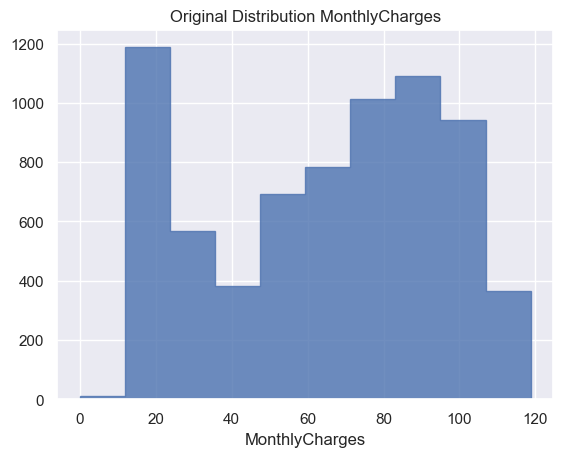

In [6]:
data_ml.MonthlyCharges.hist(histtype='step',fill=True,alpha=0.8)
plt.title('Original Distribution MonthlyCharges')
plt.xlabel('MonthlyCharges');

In [7]:
#Quantile Transforming

from sklearn.preprocessing import QuantileTransformer

#Instantiate Quantile Transformer
quantile_normal = QuantileTransformer(output_distribution='normal')

# Fit Transform X_train
X_train[['MonthlyCharges']] = quantile_normal.fit_transform(X_train[['MonthlyCharges']])

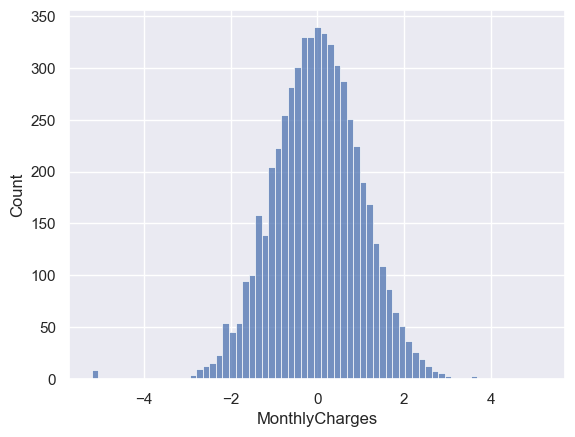

In [8]:
sns.histplot(X_train.MonthlyCharges);

In [9]:
# #Quantile Transforming

# #Instantiate Quantile Transformer
# quantile_normal = QuantileTransformer(output_distribution='normal')

# # Fit Transform X_train
# X_train[['tenure_minimal_duration']] = quantile_normal.fit_transform(X_train[['tenure_minimal_duration']])

In [10]:
# sns.histplot(X_train.tenure_minimal_duration);

## 1.6 Class Balancing

In [11]:
#Oversampling/Undersampling
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)


#https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/

# 2 Random Forest

In [53]:
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix,classification_report
from sklearn.model_selection import GridSearchCV
from mlxtend.feature_selection import SequentialFeatureSelector
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score,roc_auc_score
from sklearn.model_selection import ValidationCurveDisplay
from sklearn.model_selection import GridSearchCV
import joblib

import mlflow
from mlflow.models.signature import infer_signature
mlflow.set_tracking_uri(uri='http://127.0.0.1:8080')

## 2.1 Feature Selection

In [54]:
# from mlxtend.feature_selection import SequentialFeatureSelector
# from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs


# rf = RandomForestClassifier(n_jobs=-1,random_state=42,class_weight='balanced')

# sbs = SequentialFeatureSelector(estimator=rf,
#                                 forward=False,
#                                 scoring='accuracy',
#                                 cv=5,
#                                 k_features=1)

# sbs.fit(X_train_bal,y_train_bal)

In [55]:
# plot_sfs(sbs.get_metric_dict())
# plt.title('Sequential Backeard Selection Evaluation')
# plt.ylabel('Accuracy');

In [56]:
# sbs.subsets_[17]['feature_names']

# Extract best features for future usage(n=17)
'''best features were indetified by sbs.k_features_names and added in a new list.'''
best_features = [

    'MonthlyCharges',
    'tenure_minimal_duration',
    'gender',
    'SeniorCitizen',
    'Partner',
    'OnlineSecurity',
    'OnlineBackup',
    'DeviceProtection',
    'TechSupport',
    'PaperlessBilling',
    'MultipleLines_No phone service',
    'MultipleLines_Yes',
    'InternetService_Fiber optic',
    'Contract_One year',
    'Contract_Two year',
    'PaymentMethod_Electronic check',
    'PaymentMethod_Mailed check'
]


X_train_sbs = X_train_bal[best_features]
X_test_sbs = X_test[best_features]

## 2.2 Hyperparameter Tuning

In [57]:
# #Instantiate Random Forest
rf = RandomForestClassifier(n_jobs=-1,random_state=42,class_weight='balanced')

In [58]:
# #Dictionary for hyperparameter tuning
# rf_param_dict = {
#     'n_estimators':[50,200],
#     'max_depth': [3, 4, 5],
#     'min_samples_leaf': [5, 10, 15],
#     'max_features': ['sqrt', 'log2'],
#     'max_samples': [0.7, 1.0]
# }

# #Instantiate GridsearchCV
# gridcv_rf = GridSearchCV(estimator=rf,cv=5,param_grid=rf_param_dict,scoring='accuracy')

# #Fit Gridsearch with training data
# model_rf = gridcv_rf.fit(X_train_sbs,y_train_bal)

# #Best params
# best_params_rf = model_rf.best_params_

# #Best score
# best_score_rf = model_rf.best_score_

# #Mean test score
# mean_test_score_rf = model_rf.cv_results_['mean_test_score']

In [59]:
# # Tracking Experiment

# mlflow.set_experiment('Churn Prediction Telco Data')


# #start MlFlow run
# with mlflow.start_run():
#     mlflow.log_param("best_params", best_params_rf)
#     mlflow.log_param("param_dict", rf_param_dict)
#     mlflow.log_metric('accuracy', best_score_rf)
#     mlflow.set_tag("Training Info", "Random Forest with Sequential Backward Selection n=17")

#     best_model_rf = model_rf.best_estimator_

#     # Infer signature
#     signature = infer_signature(X_train_sbs, model_rf.predict(X_train_sbs))

#     # Log Model
#     model_info_rf = mlflow.sklearn.log_model(
#         sk_model=model_rf,
#         artifact_path="Random Forest",
#         signature=signature,
#         input_example=X_train_bal,
#         registered_model_name="Random Forest"
#     )

## 2.3 Testing and Evaluation

In [ ]:
#Load best model from mlflow
best_model_cv = mlflow.sklearn.load_model(f"models:/Random Forest/11")
print(best_model_cv.get_params)

# Instantiate best model
best_model = best_model_cv.best_estimator_

#training best model
best_model = best_model.fit(X_train_bal,y_train_bal)

# X_test_sbs = X_test[best_features]

#testing best model
y_pred_best_model = best_model.predict(X_test)

<bound method BaseEstimator.get_params of GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              n_jobs=-1, random_state=42),
             param_grid={'max_depth': [3, 4, 5],
                         'max_features': ['sqrt', 'log2'],
                         'max_samples': [0.7, 1.0],
                         'min_samples_leaf': [5, 10, 15],
                         'n_estimators': [50, 200]},
             scoring='accuracy')>


In [61]:
# Classification Report
class_report = classification_report(y_test, y_pred_best_model, target_names=best_model.classes_.astype(str))
print(class_report)

              precision    recall  f1-score   support

           0       0.88      0.78      0.83      1035
           1       0.54      0.71      0.61       371

    accuracy                           0.76      1406
   macro avg       0.71      0.75      0.72      1406
weighted avg       0.79      0.76      0.77      1406



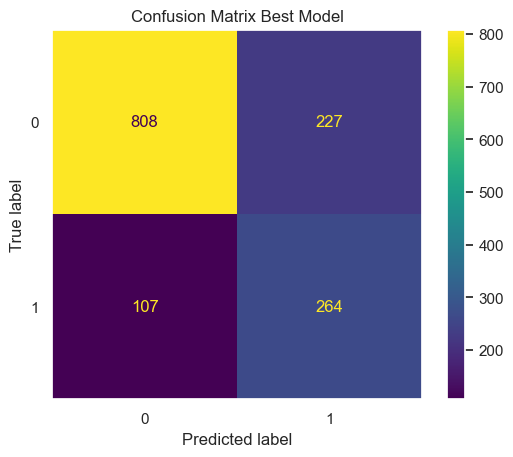

In [62]:
#Confusion Matrix
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred_best_model)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('Confusion Matrix Best Model')
plt.grid()

## 2.4 Feature Importance

In [ ]:
from sklearn.inspection import permutation_importance

# Extract feature names from best model
feature_names = best_model.feature_names_in_

# Permutation importance
result = permutation_importance(best_model, X_test, y_test, n_repeats=50, random_state=42, n_jobs=2)

forest_importances = pd.Series(result.importances_mean, index=feature_names)

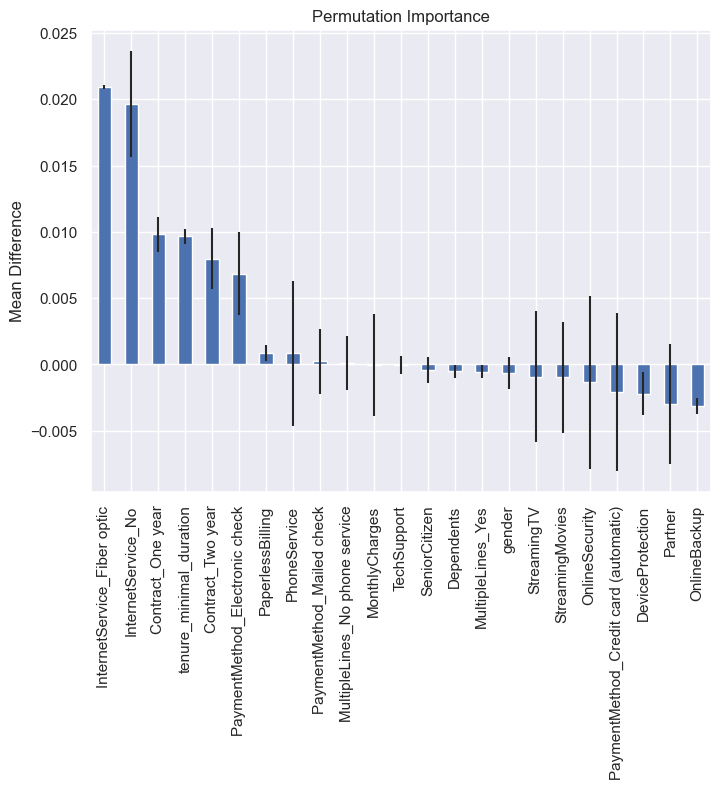

In [64]:
plt.figure(figsize=(8,6))
forest_importances.sort_values(ascending=False).plot(kind='bar', yerr=result.importances_std)
plt.title('Permutation Importance')
plt.ylabel('Mean Difference');

## 2.5 Retraining with best features

In [65]:
# Filter features difference > 0
positive_features = forest_importances[forest_importances > 0]

# Indexing X_train on positive features
X_train_positive_features = X_train_bal[positive_features.index]

# Indexing X_test on positive features
X_test_positive_features = X_test[positive_features.index]

# Training best model with positive features
best_model_positive_feature = best_model.fit(X_train_positive_features,y_train_bal)

# Testing best model with positives features
y_pred_best_model_positive_bal = best_model_positive_feature.predict(X_test_positive_features)

# Accuracy Score
accuracy_positive_feature = accuracy_score(y_pred=y_pred_best_model_positive_bal, y_true=y_test)

In [66]:
# Tracking Experiment
# mlflow.set_experiment('Churn Prediction Telco Data')

# with mlflow.start_run():
#     mlflow.log_metric('accuracy', accuracy_positive_feature)
#     mlflow.set_tag("Training Info", "Random Forest with permutated features")

#     signature = infer_signature(
#         X_train_positive_features,
#         best_model_positive_feature.predict(X_train_positive_features)
#     )

#     mlflow.sklearn.log_model(
#         sk_model=best_model_positive_feature,
#         artifact_path="Random Forest",
#         signature=signature,
#         input_example=X_train_positive_features.head(5),
#         registered_model_name="Random Forest"
#     )

In [67]:
#Load best model from mlflow
model_permutated_feature = mlflow.sklearn.load_model(f"models:/Random Forest/20")

In [68]:
# Classification Report with positive features
class_report_pos_features = classification_report(y_test, y_pred_best_model_positive_bal, target_names=best_model_positive_feature.classes_.astype(str))
print(class_report_pos_features)


              precision    recall  f1-score   support

           0       0.89      0.77      0.83      1035
           1       0.54      0.73      0.62       371

    accuracy                           0.76      1406
   macro avg       0.71      0.75      0.72      1406
weighted avg       0.80      0.76      0.77      1406



In [ ]:
# Extract feature names
feature_names = best_model.feature_names_in_

# Permutation importance
result = permutation_importance(best_model_positive_feature, X_test_positive_features, y_test, n_repeats=50, random_state=42, n_jobs=2)


feature_names = X_test_positive_features.columns
forest_importances = pd.Series(result.importances_mean, index=feature_names)

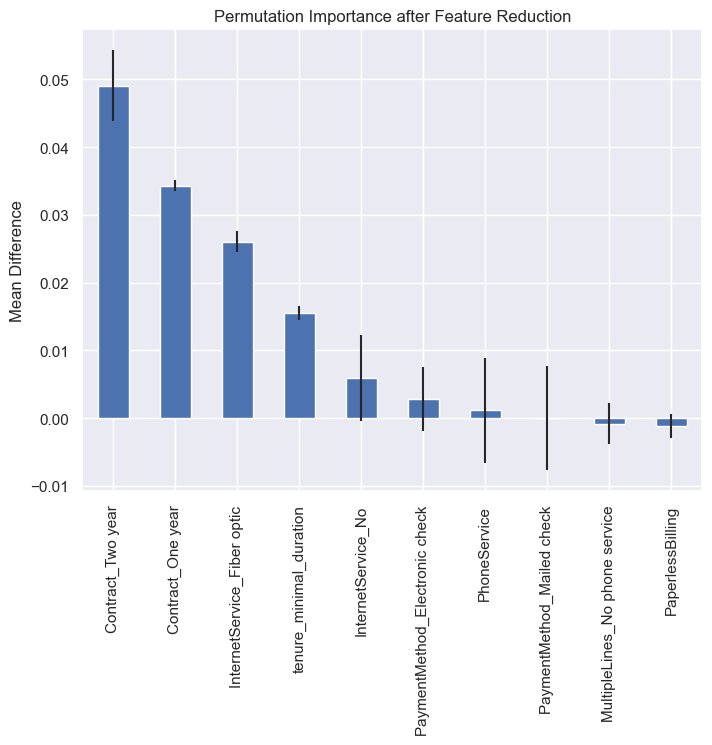

In [70]:
plt.figure(figsize=(8,6))
forest_importances.sort_values(ascending=False).plot(kind='bar', yerr=result.importances_std)
plt.title('Permutation Importance after Feature Reduction')
plt.ylabel('Mean Difference');

# 3 Neuronal Network

In [11]:
# Train Test Split for Neuronal Network
X_train_nn, X_test_nn, y_train_nn, y_test_nn = train_test_split(X,y,test_size=0.2,stratify=y,random_state=123)

# Split Trainset into train und validation set
X_train_nn_train, X_val, y_train_nn_train, y_val = train_test_split(X_train_nn, y_train_nn, test_size=0.2, stratify=y_train_nn, random_state=123)

# Fit Transform Monthly Charges in X_train_nn_train
X_train_nn_train[['MonthlyCharges']] = quantile_normal.fit_transform(X_train_nn_train[['MonthlyCharges']])

# Transform X_val
X_val[['MonthlyCharges']]  = quantile_normal.transform(X_val[['MonthlyCharges']])

# Transform X_test_nn
X_test_nn[['MonthlyCharges']] = quantile_normal.transform(X_test_nn[['MonthlyCharges']])

In [12]:
import tensorflow as tf
import keras_tuner as kt
from sklearn.utils import class_weight as cw

def build_model(hp):
    n_hidden = hp.Int('n_hidden',min_value=0,max_value=4,default=2)
    n_neurons = hp.Int('n_neurons',min_value=16,max_value=256)
    learning_rate = hp.Float('learning_rate',min_value=0.005,max_value=0.01,sampling='log')
    optimizer = hp.Choice('optimizer',values=['sgd','adam'])

    if optimizer == 'sgd':
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    else:
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    model = tf.keras.Sequential()
    for _ in range(n_hidden):
        model.add(tf.keras.layers.Dense(n_neurons,activation='relu',input_shape=(23,)))
        model.add(tf.keras.layers.Dropout(rate=0.5))
    model.add(tf.keras.layers.Dense(1,activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])
    
    return model


random_search_tuner = kt.RandomSearch(
    build_model, objective='val_accuracy',max_trials=5, overwrite=True,
    directory=r"C:\Users\flori\Documents\Python_Ordner\churn_prediction",project_name='neuronal_network_v1',seed=42)


class_weight = cw.compute_class_weight('balanced', classes=np.unique(y_train_nn), y=y_train_nn)
class_weights_dict = dict(enumerate(class_weight))

random_search_tuner.search(X_train_nn_train,y_train_nn_train, epochs=10,validation_data=(X_val, y_val),class_weight=class_weights_dict)


Trial 5 Complete [00h 00m 04s]
val_accuracy: 0.7573333382606506

Best val_accuracy So Far: 0.7831110954284668
Total elapsed time: 00h 00m 23s


In [13]:
random_search_tuner.oracle.get_best_trials(num_trials=1)[0].summary()

Trial 2 summary
Hyperparameters:
n_hidden: 2
n_neurons: 74
learning_rate: 0.009851087193828375
optimizer: adam
Score: 0.7831110954284668


In [ ]:
# Get best model
best_model_nn = random_search_tuner.get_best_models(num_models=1)[0]

# Evaluate training metrics
train_loss, train_accuracy, = best_model_nn.evaluate(X_train_nn_train, y_train_nn_train, verbose=0)
print(f'train_loss: {train_loss}, train_accuracy: {train_accuracy}')

# Evaluate validation metrics
val_loss, val_acc = best_model_nn.evaluate(X_val, y_val, verbose=0)
print(f'val_loss: {val_loss}, val_accuracy: {val_acc}')

c:\Users\flori\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\flori\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


train_loss: 0.43176060914993286, train_accuracy: 0.8004000782966614
val_loss: 0.44406750798225403, val_accuracy: 0.7831110954284668


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils import class_weight as cw

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=0)

# Fit best model
history = best_model_nn.fit(
    X_train_nn, y_train_nn,
    validation_split=0.2,
    class_weight=class_weights_dict,
    epochs=100,
    callbacks=[early_stopping],
    verbose=2
)

Epoch 1/100


c:\Users\flori\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\flori\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


141/141 - 1s - 10ms/step - accuracy: 0.6413 - loss: 0.9622 - val_accuracy: 0.7902 - val_loss: 0.5483
Epoch 2/100
141/141 - 0s - 3ms/step - accuracy: 0.6930 - loss: 0.6175 - val_accuracy: 0.8284 - val_loss: 0.5571
Epoch 3/100
141/141 - 0s - 3ms/step - accuracy: 0.7186 - loss: 0.5947 - val_accuracy: 0.7991 - val_loss: 0.4591
Epoch 4/100
141/141 - 0s - 2ms/step - accuracy: 0.7282 - loss: 0.5828 - val_accuracy: 0.8231 - val_loss: 0.4606
Epoch 5/100
141/141 - 0s - 2ms/step - accuracy: 0.7239 - loss: 0.5793 - val_accuracy: 0.8240 - val_loss: 0.4832
Epoch 6/100
141/141 - 0s - 2ms/step - accuracy: 0.7288 - loss: 0.5586 - val_accuracy: 0.8133 - val_loss: 0.4726
Epoch 7/100
141/141 - 0s - 2ms/step - accuracy: 0.7353 - loss: 0.5611 - val_accuracy: 0.8213 - val_loss: 0.4439
Epoch 8/100
141/141 - 0s - 2ms/step - accuracy: 0.7417 - loss: 0.5627 - val_accuracy: 0.7556 - val_loss: 0.5171
Epoch 9/100
141/141 - 0s - 2ms/step - accuracy: 0.7386 - loss: 0.5581 - val_accuracy: 0.7831 - val_loss: 0.4602
Epo

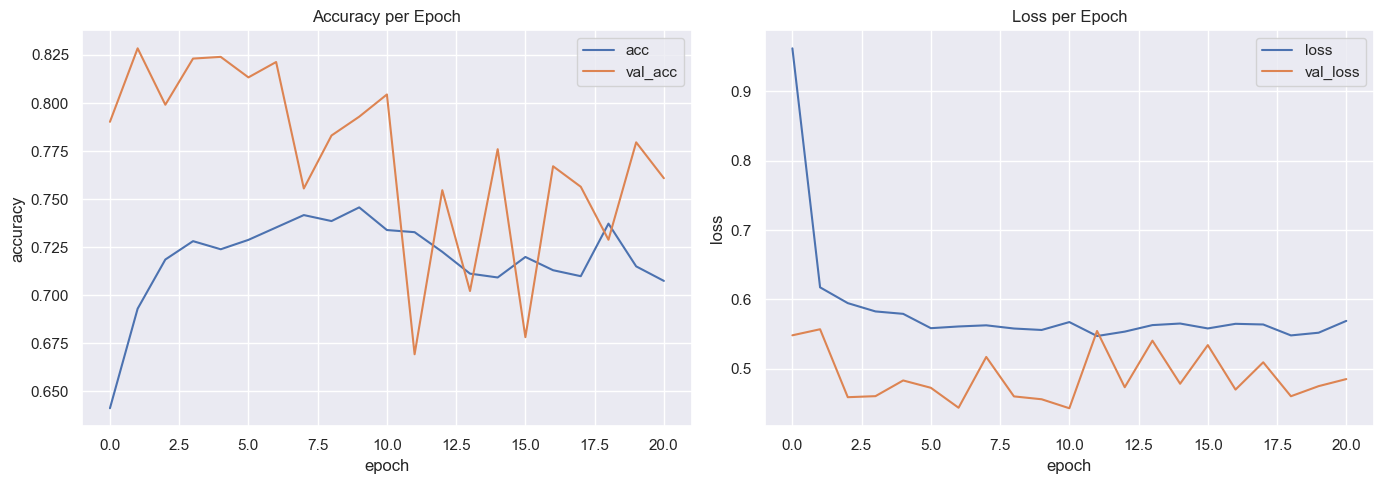

In [ ]:
# Plot Performance
plt.figure(figsize=(14,5))

# Subplot Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label = 'acc')
plt.plot(history.history['val_accuracy'], label = 'val_acc')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(loc='upper right')
plt.title('Accuracy per Epoch')

# Subplot Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc='upper right')
plt.title('Loss per Epoch')

plt.tight_layout()

In [ ]:
# Evaluate full training set
train_loss_full, train_accuracy_full = best_model_nn.evaluate(X_train_nn, y_train_nn, verbose=0)
train_loss_full, train_accuracy_full

(0.4808524549007416, 0.7756045460700989)

In [ ]:
# Evaluate test set
test_loss, test_accuracy, = best_model_nn.evaluate(X_test_nn, y_test_nn)

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7721 - loss: 0.6375
